In [49]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from lib.i_o import read_csv

## 0) Read data

In [50]:
df_x_train = read_csv("X_train.csv", "../data/").drop(columns="id")
df_y_train = read_csv("y_train.csv", "../data/").drop(columns="id")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [51]:
df_x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [52]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

In [53]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 832
#observations: 1212


## 1) Developing a model

### 1.1) Finding an optimal model

In [72]:
selector_model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.02,
    random_state = 42,
    device='gpu'
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__device="gpu",
    regression_model__n_estimators=1000,
    regression_model__learning_rate=0.005,
    regression_model__subsample=0.6
)

Pipeline(steps=[('scaler', RobustScaler()), ('imputer', KNNImputer()),
                ('feature_selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device='gpu',
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        g...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.005,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [73]:
start_t = time()

pipe.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 1.026 min


In [75]:
train_pred = pipe.predict(X_train)
val_pred = pipe.predict(X_val)

validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}") # 

Training score 0.961
Validation score 0.521


### 1.2) Tuning of hyperparameters of the optimal model

Goal: Find optimal hyperparameters of the optimal model found. 

In [9]:
# Rewrite preprocessing and model as a sklearn pipeline
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.02,
    random_state = 42
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__n_jobs=4
)

# Set grid / solution space
parameters = {
    'regression_model__n_estimators': [1000],
    'regression_model__learning_rate': [0.005],
    'regression_model__subsample': np.arange(0.45, 0.8, 0.03)
}

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=2, cv=5, return_train_score=True)
grided_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 88.821 min


In [10]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [11]:
grided_model.cv_results_["params"]

[{'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.45},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.48},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.51},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.5399999999999999},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.5699999999999998},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.5999999999999999},
 {'regression_model__learning_rate': 0.005,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.6299999999999999},
 {'regression_model__learning_rate': 0.005,
  'regression_mode

In [14]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    #'regression_model__max_depth',
    #, 'feature_selector__threshold'
    #, 'regression_model__n_estimators'
    #, 'feature_selector__threshold'
    #, 'regression_model__max_features'
    'regression_model__subsample',
    #, 'regression_model__learning_rate'
]]

,mean_test_score,mean_train_score,std_test_score,std_train_score,regression_model__subsample
4,0.480683,0.964652,0.059363,0.003899,0.57
2,0.479166,0.955235,0.061878,0.004859,0.51
8,0.478978,0.976806,0.056329,0.003159,0.69
3,0.478814,0.960144,0.060180,0.004118,0.54
1,0.478322,0.950360,0.060638,0.005000,0.48
0,0.478090,0.944862,0.058547,0.004904,0.45
5,0.477049,0.968392,0.057791,0.003382,0.60
9,0.474589,0.979464,0.059028,0.002507,0.72
7,0.474308,0.974363,0.060862,0.003146,0.66
6,0.474151,0.971459,0.059302,0.003494,0.63


In [25]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    'regression_model__n_estimators',
    'regression_model__max_depth',
    'regression_model__subsample',
    'regression_model__learning_rate'
]].loc[1]

mean_test_score                       0.475099
mean_train_score                      0.684808
std_test_score                        0.049023
std_train_score                       0.008239
regression_model__n_estimators     1000.000000
regression_model__max_depth           2.000000
regression_model__subsample           0.600000
regression_model__learning_rate       0.005000
Name: 1, dtype: float64

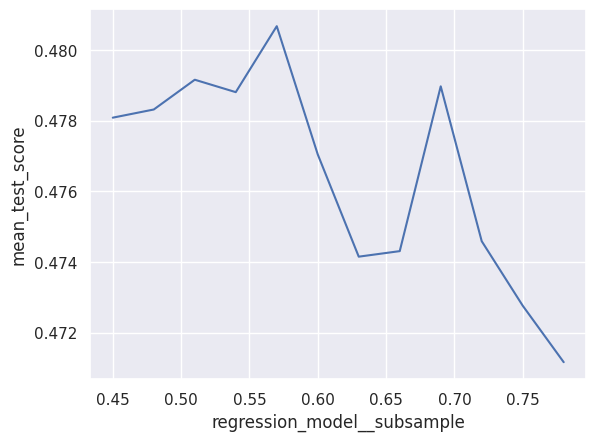

In [15]:
sns.lineplot(data=df_cv_results, x= 'regression_model__subsample', y='mean_test_score');

<Axes: xlabel='regression_model__subsample', ylabel='mean_train_score'>

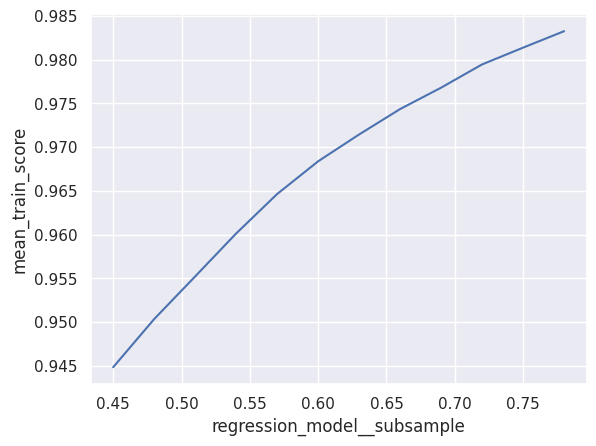

In [16]:
sns.lineplot(data=df_cv_results, x= 'regression_model__subsample', y='mean_train_score')

In [29]:
train_pred = grided_model.predict(X_train)
val_pred = grided_model.predict(X_val)

validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}") # 

Training score 0.872
Validation score 0.539


## 2) Model testing

In the previous step, an optimal model with its hyperparameters is found. Now we want to derive testing / evaluation metrics to compare it with other previously optimal models. 

### 25-Fold CV

In [30]:
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.02,
    random_state = 42
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__device="gpu"
)

# Set grid / solution space
parameters = {
    'regression_model__n_estimators': [1000],
    'regression_model__learning_rate': [0.005],
    'regression_model__subsample': [0.6],
    'regression_model__max_depth': [4]

}

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', cv=25, return_train_score=True)
grided_model.fit(df_x_train, np.array(df_y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:47:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Elapsed time 44.4 min


In [31]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [32]:
df_cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regression_model__learning_rate',
       'param_regression_model__max_depth',
       'param_regression_model__n_estimators',
       'param_regression_model__subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'split10_test_score', 'split11_test_score', 'split12_test_score',
       'split13_test_score', 'split14_test_score', 'split15_test_score',
       'split16_test_score', 'split17_test_score', 'split18_test_score',
       'split19_test_score', 'split20_test_score', 'split21_test_score',
       'split22_test_score', 'split23_test_score', 'split24_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score'

In [33]:
grided_model.cv_results_["params"]

[{'regression_model__learning_rate': 0.005,
  'regression_model__max_depth': 4,
  'regression_model__n_estimators': 1000,
  'regression_model__subsample': 0.6}]

In [34]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    'mean_fit_time', 
    'std_fit_time'
]]

,mean_test_score,mean_train_score,std_test_score,std_train_score,mean_fit_time,std_fit_time
0,0.50769,0.841051,0.123177,0.002923,99.71119,1.962166


In [46]:
start_t = time()
pipe.fit(X_train, np.array(y_train).ravel())
print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 1.814 min


In [48]:
pipe.transform(X_train).shape

(875, 234)

In [44]:
train_pred = pipe.predict(X_train)
val_pred = pipe.predict(X_val)

validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}") # 

Training score 0.953
Validation score 0.537


## 3) Make predictions

In the previous steps, the final model with its optimal hyperparameters is found. Now we train this model on the entire training data and make predictions for the submission. 

In [35]:
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.02,
    random_state = 42
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__device="gpu",
    regression_model__n_estimators=1000,
    regression_model__learning_rate=0.005,
    regression_model__subsample=0.6,
)

# Train grided model
pipe.fit(df_x_train, np.array(df_y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 1.746 min


In [36]:
df_sample = read_csv("sample.csv", "../data/")

Read data from ../data/sample.csv


In [37]:
df_sample.head()

,id,y
0,0.0,69.889439
1,1.0,69.889439
2,2.0,69.889439
3,3.0,69.889439
4,4.0,69.889439


In [38]:
df_x_test = read_csv("X_test.csv", "../data/").drop(columns="id")

Read data from ../data/X_test.csv


In [39]:
df_sample['y'] = pipe.predict(df_x_test)

In [40]:
df_sample.head()

,id,y
0,0.0,60.761215
1,1.0,76.611221
2,2.0,70.259369
3,3.0,72.860672
4,4.0,74.182205


In [41]:
df_sample.to_csv("../data/df_predictions.csv", index=False)